In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from utils_db import load_table
from preprocess import drop_nan_df, analyze_df, clean_numstr

pd.set_option("display.max_columns", None)

In [2]:
# load table
df_raw = load_table("cars")
df_raw.head()

,car_id,url,brand,model,price,postcode,production_year,mileage,gearbox,energy,attrs,crawled_at
0,701,https://www.lacentrale.fr/auto-occasion-annonc...,FERRARI,FERRARI 348,85 900 €,75016,1991,21 600 km,Manuelle,Essence,"{'Couleur': 'ROUGE FONCE', 'Sellerie': 'Noir',...",2025-05-22 17:59:50.761955
1,745,https://www.lacentrale.fr/auto-occasion-annonc...,CITROEN,CITROEN C3 III phase 2,12 990 €,33700,None,None,None,None,{'': ''},2025-05-22 18:27:18.279740
2,746,https://www.lacentrale.fr/auto-occasion-annonc...,AUDI,AUDI A3 II phase 3,9 990 €,95200,None,None,None,None,{'': ''},2025-05-22 18:28:45.179853
3,877,https://www.lacentrale.fr/auto-occasion-annonc...,FORD,FORD TOURNEO CUSTOM II FOURGON II phase 2,45 064 €,,2025,10 km,Manuelle,Diesel,"{'Couleur': 'blanc', 'Crit'Air': '', 'Norme eu...",2025-05-23 17:39:06.591229
4,1048,https://www.lacentrale.fr/auto-occasion-annonc...,MERCEDES,MERCEDES CLA phase 2,24 488 €,,2018,92 150 km,Automatique,Diesel,"{'Couleur': 'blanc', 'Crit'Air': '', 'Norme eu...",2025-05-23 19:47:47.443493


In [3]:
def expand_df(df_raw: pd.DataFrame)-> pd.DataFrame:
    # Expand attrs
    df_attrs = pd.json_normalize(df_raw["attrs"])
    df = pd.concat([df_raw.drop(columns=["attrs"]), df_attrs], axis=1)
    rename_map = {
        'Couleur': 'color',
        'Provenance': 'provenance',
        'Première main': 'first_hand',
        'Nombre de places': 'num_places',
        'Contrôle technique': 'control_technique',
        'Mise en circulation': 'circulation_date',
        'Norme euro': 'norm_euro',
        'Puissance DIN': 'power_DIN',
        'Nombre de portes': 'num_doors',
        'Puissance fiscale': 'power_tax',
        'Longueur': 'length',
        'Emission de CO2': 'emission_CO2'
    } 
    df = df.rename(columns=rename_map)
    

    # Drop unwanted columns
    df.drop(columns=["car_id", "url", "crawled_at", "Crit'Air"], inplace=True)

    return df


def format_df(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()

    numstr_cols = [
        "price", "mileage", "power_DIN", "power_tax", "length",
        "emission_CO2",
    ]
    for col in numstr_cols:
        df[col] = df[col].apply(clean_numstr)

    int_cols = [
        "price", "production_year", "mileage", "num_places", "power_DIN", 
        "num_doors", "power_tax", "emission_CO2"
    ]
    for col in int_cols:
        df[col] = df[col].astype(int)

    df["length"] = df["length"].astype(float)

    df["postcode"] = np.where(
        df["postcode"] == "",
        "unknown",
        df["postcode"].str[:2]
    )

    df["circulation_date"] = pd.to_datetime(df["circulation_date"], format="%d/%m/%Y")
    df["circulation_year"] = df["circulation_date"].dt.year
    df.drop(columns=["circulation_date"], inplace=True)

    return df


df = expand_df(df_raw)
df = drop_nan_df(df)
df = format_df(df)
df.head()

,brand,model,price,postcode,production_year,mileage,gearbox,energy,color,provenance,first_hand,num_places,control_technique,norm_euro,power_DIN,num_doors,power_tax,length,emission_CO2,circulation_year
8,FORD,FORD TRANSIT IV phase 2,19780,54,2020,87308,Manuelle,Diesel,Blanc,Non renseignée,Oui,3,Requis,EURO6,170,2,7,5.84,284,2020
9,SEAT,SEAT IBIZA IV,4980,72,2011,195000,Manuelle,Diesel,blanc,Non renseignée,Non,5,Requis,EURO5,75,5,4,4.03,99,2011
10,BMW,BMW SERIE 5 G60,87900,77,2025,7000,Automatique,Diesel,gris,Non renseignée,Oui,5,Non requis,EURO6,197,4,11,5.06,144,2025
11,ASTON MARTIN,ASTON MARTIN DB9 VOLANTE,114990,75,2016,37995,Automatique,Essence,gris,Non renseignée,Non,4,Requis,EURO6,548,2,48,4.69,325,2016
12,OPEL,OPEL MOKKA II,23900,10,2024,13912,Manuelle,Essence,blanc,Non renseignée,Non,5,Non requis,EURO6,136,5,7,4.15,127,2024


In [4]:
analyze_df(df)


-- shape --

(1091, 20)

-- data type --

brand                 object
model                 object
price                  int64
postcode              object
production_year        int64
mileage                int64
gearbox               object
energy                object
color                 object
provenance            object
first_hand            object
num_places             int64
control_technique     object
norm_euro             object
power_DIN              int64
num_doors              int64
power_tax              int64
length               float64
emission_CO2           int64
circulation_year       int32
dtype: object

-- unique values count --

brand                  40
model                 494
price                 518
postcode               81
production_year        26
mileage              1010
gearbox                 2
energy                  8
color                 318
provenance              3
first_hand              2
num_places              8
control_technique      

# Distribution

1. Extreme values in price. -> log transform.
2. Too many categories in model, postcode. -> TargetEncoder
3. Too many categories in energy, color. -> Rare Encoding

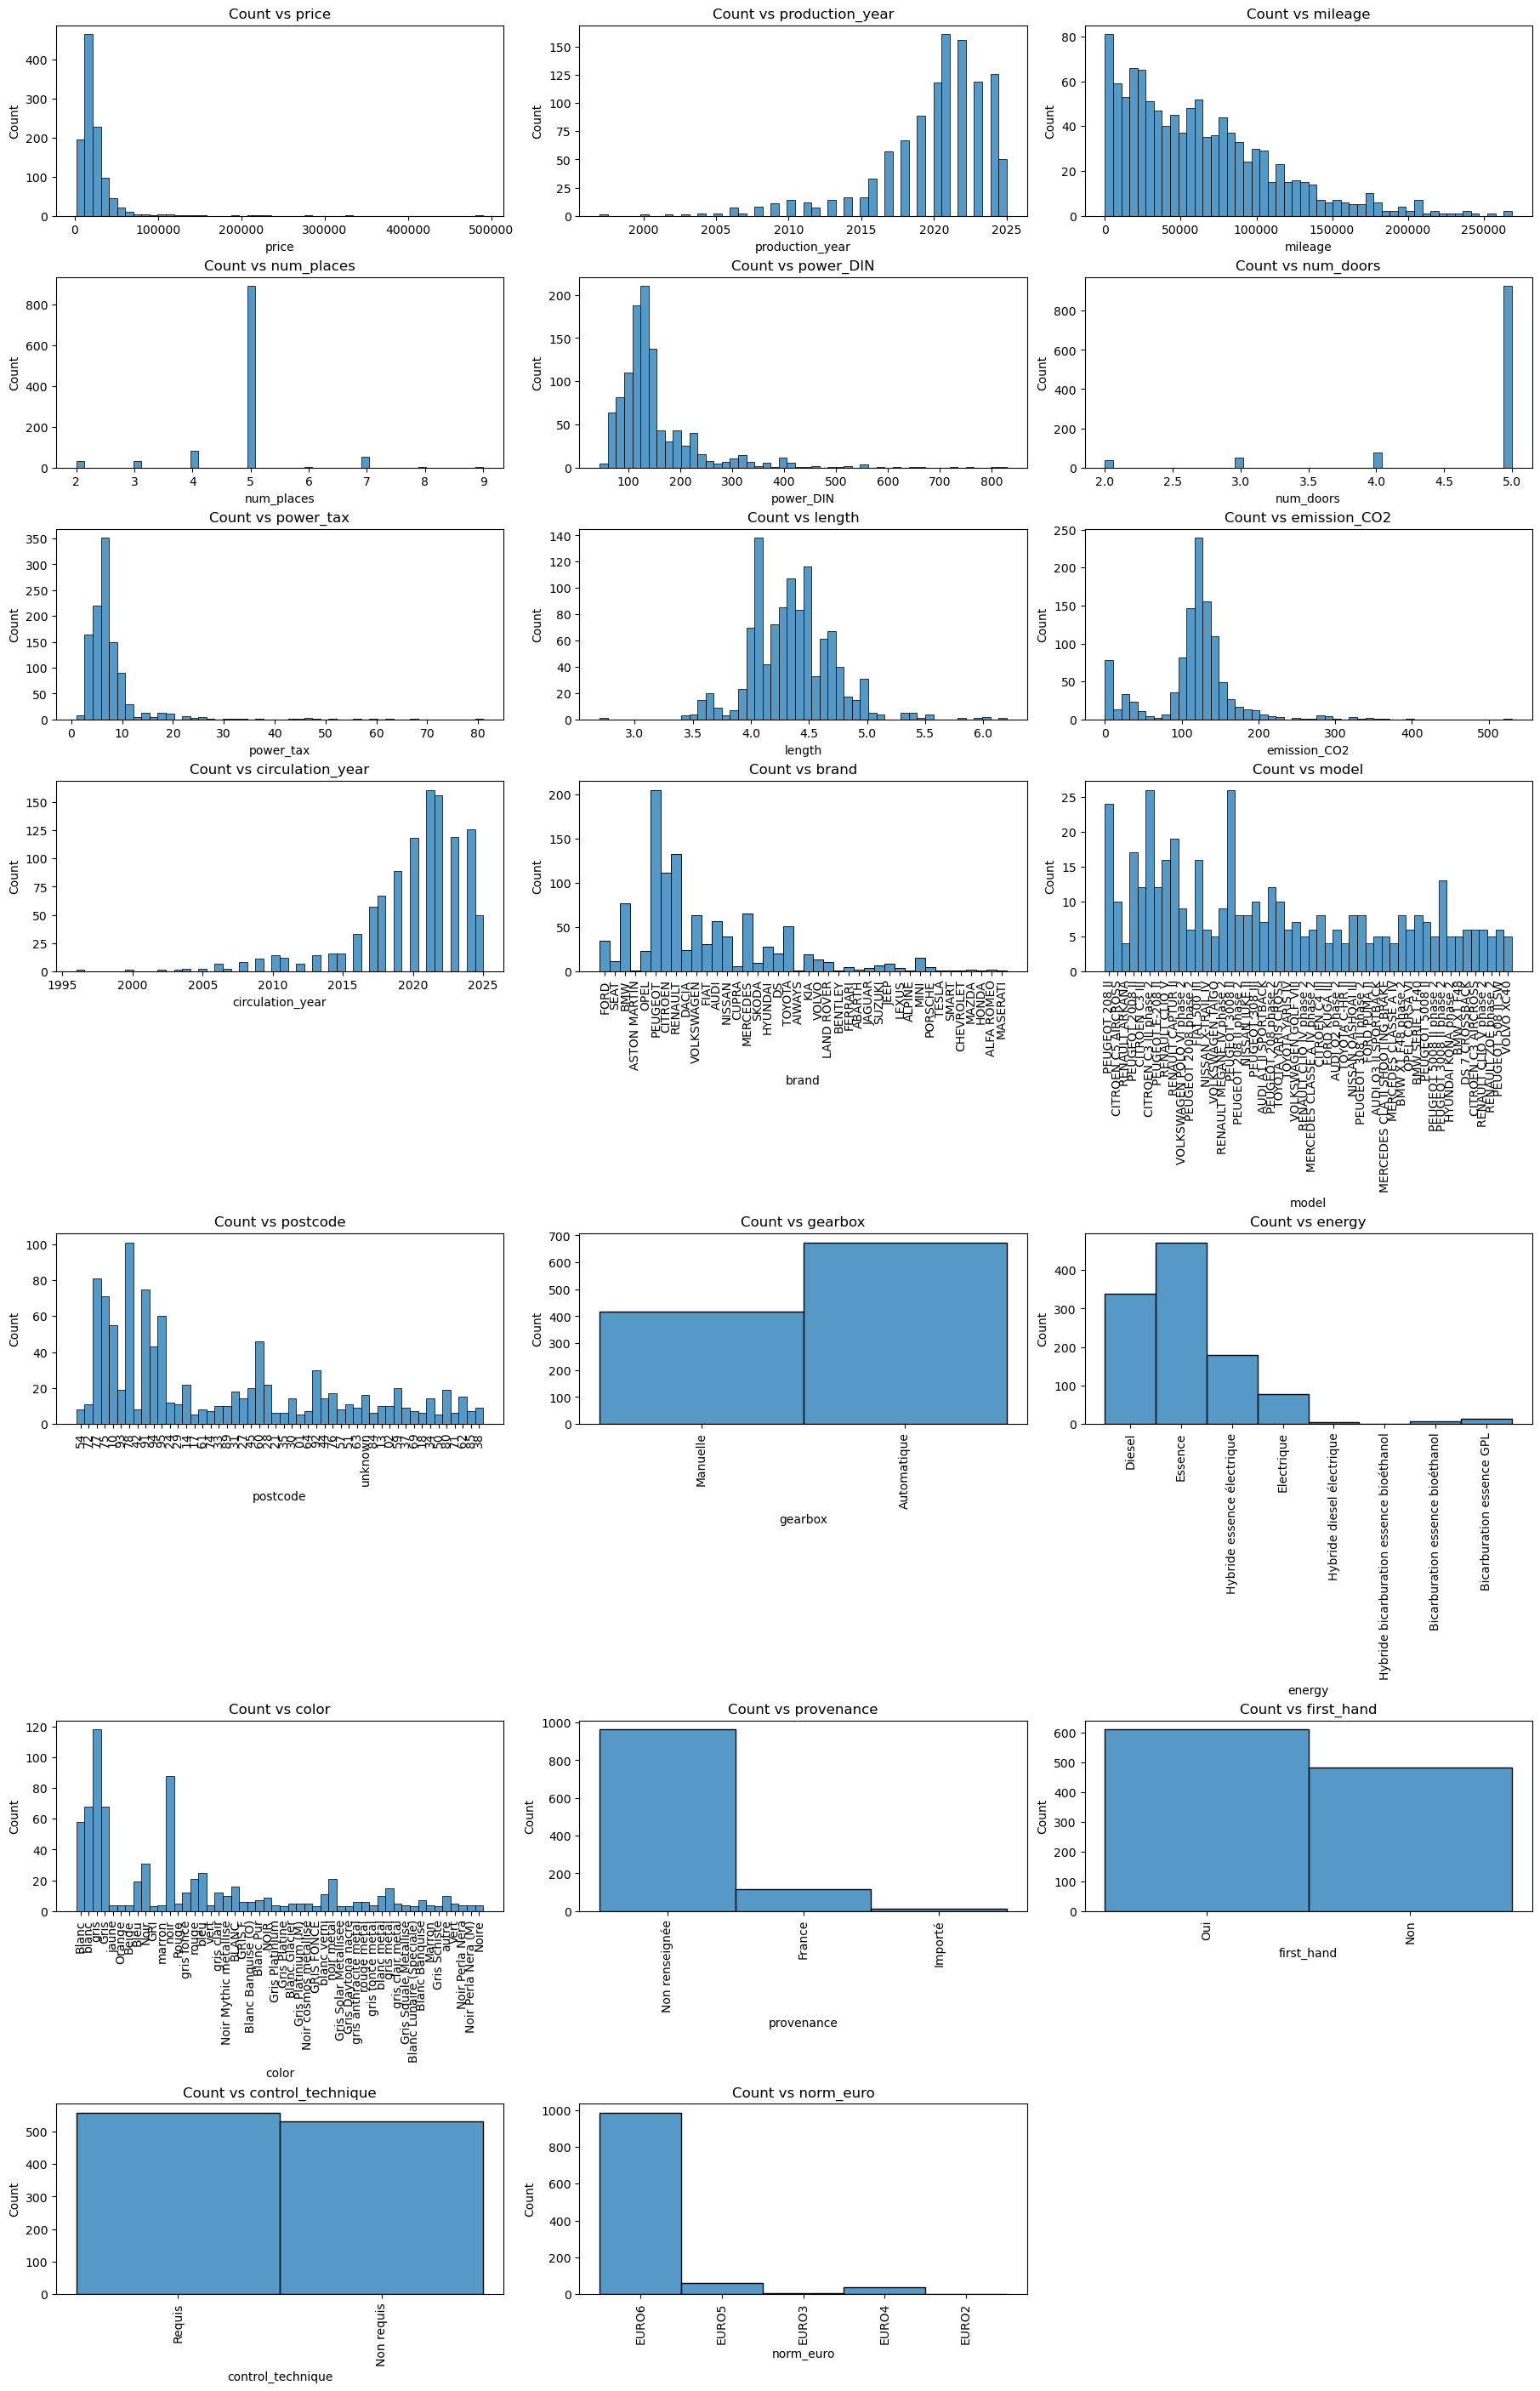

In [5]:
def plot_count_vs_features(df: pd.DataFrame):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    all_cols = numerical_cols + categorical_cols
    
    c = 3
    r = math.ceil(len(all_cols) / c)
    fig, axes = plt.subplots(r, c, figsize=(c * 6, r * 4), constrained_layout=True)
    axes = axes.flatten()
    topk = 50
    
    for i, col in enumerate(all_cols):
        ax = axes[i]
        
        if col in numerical_cols:
            sns.histplot(data=df, x=col, bins=50, ax=ax, kde=False)
        else:
            # Keep top frequent categories
            top_categories = df[col].value_counts().nlargest(topk).index.tolist()
            df_filtered = df[df[col].isin(top_categories)]
            sns.histplot(data=df_filtered, x=col, bins=50, ax=ax, kde=False)
            ax.tick_params(axis='x', labelrotation=90)
        ax.set_title(f"Count vs {col}")
    # Hide unused axes
    for j in range(len(all_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.savefig("results/count_vs_features.png")
    plt.show()


plot_count_vs_features(df)

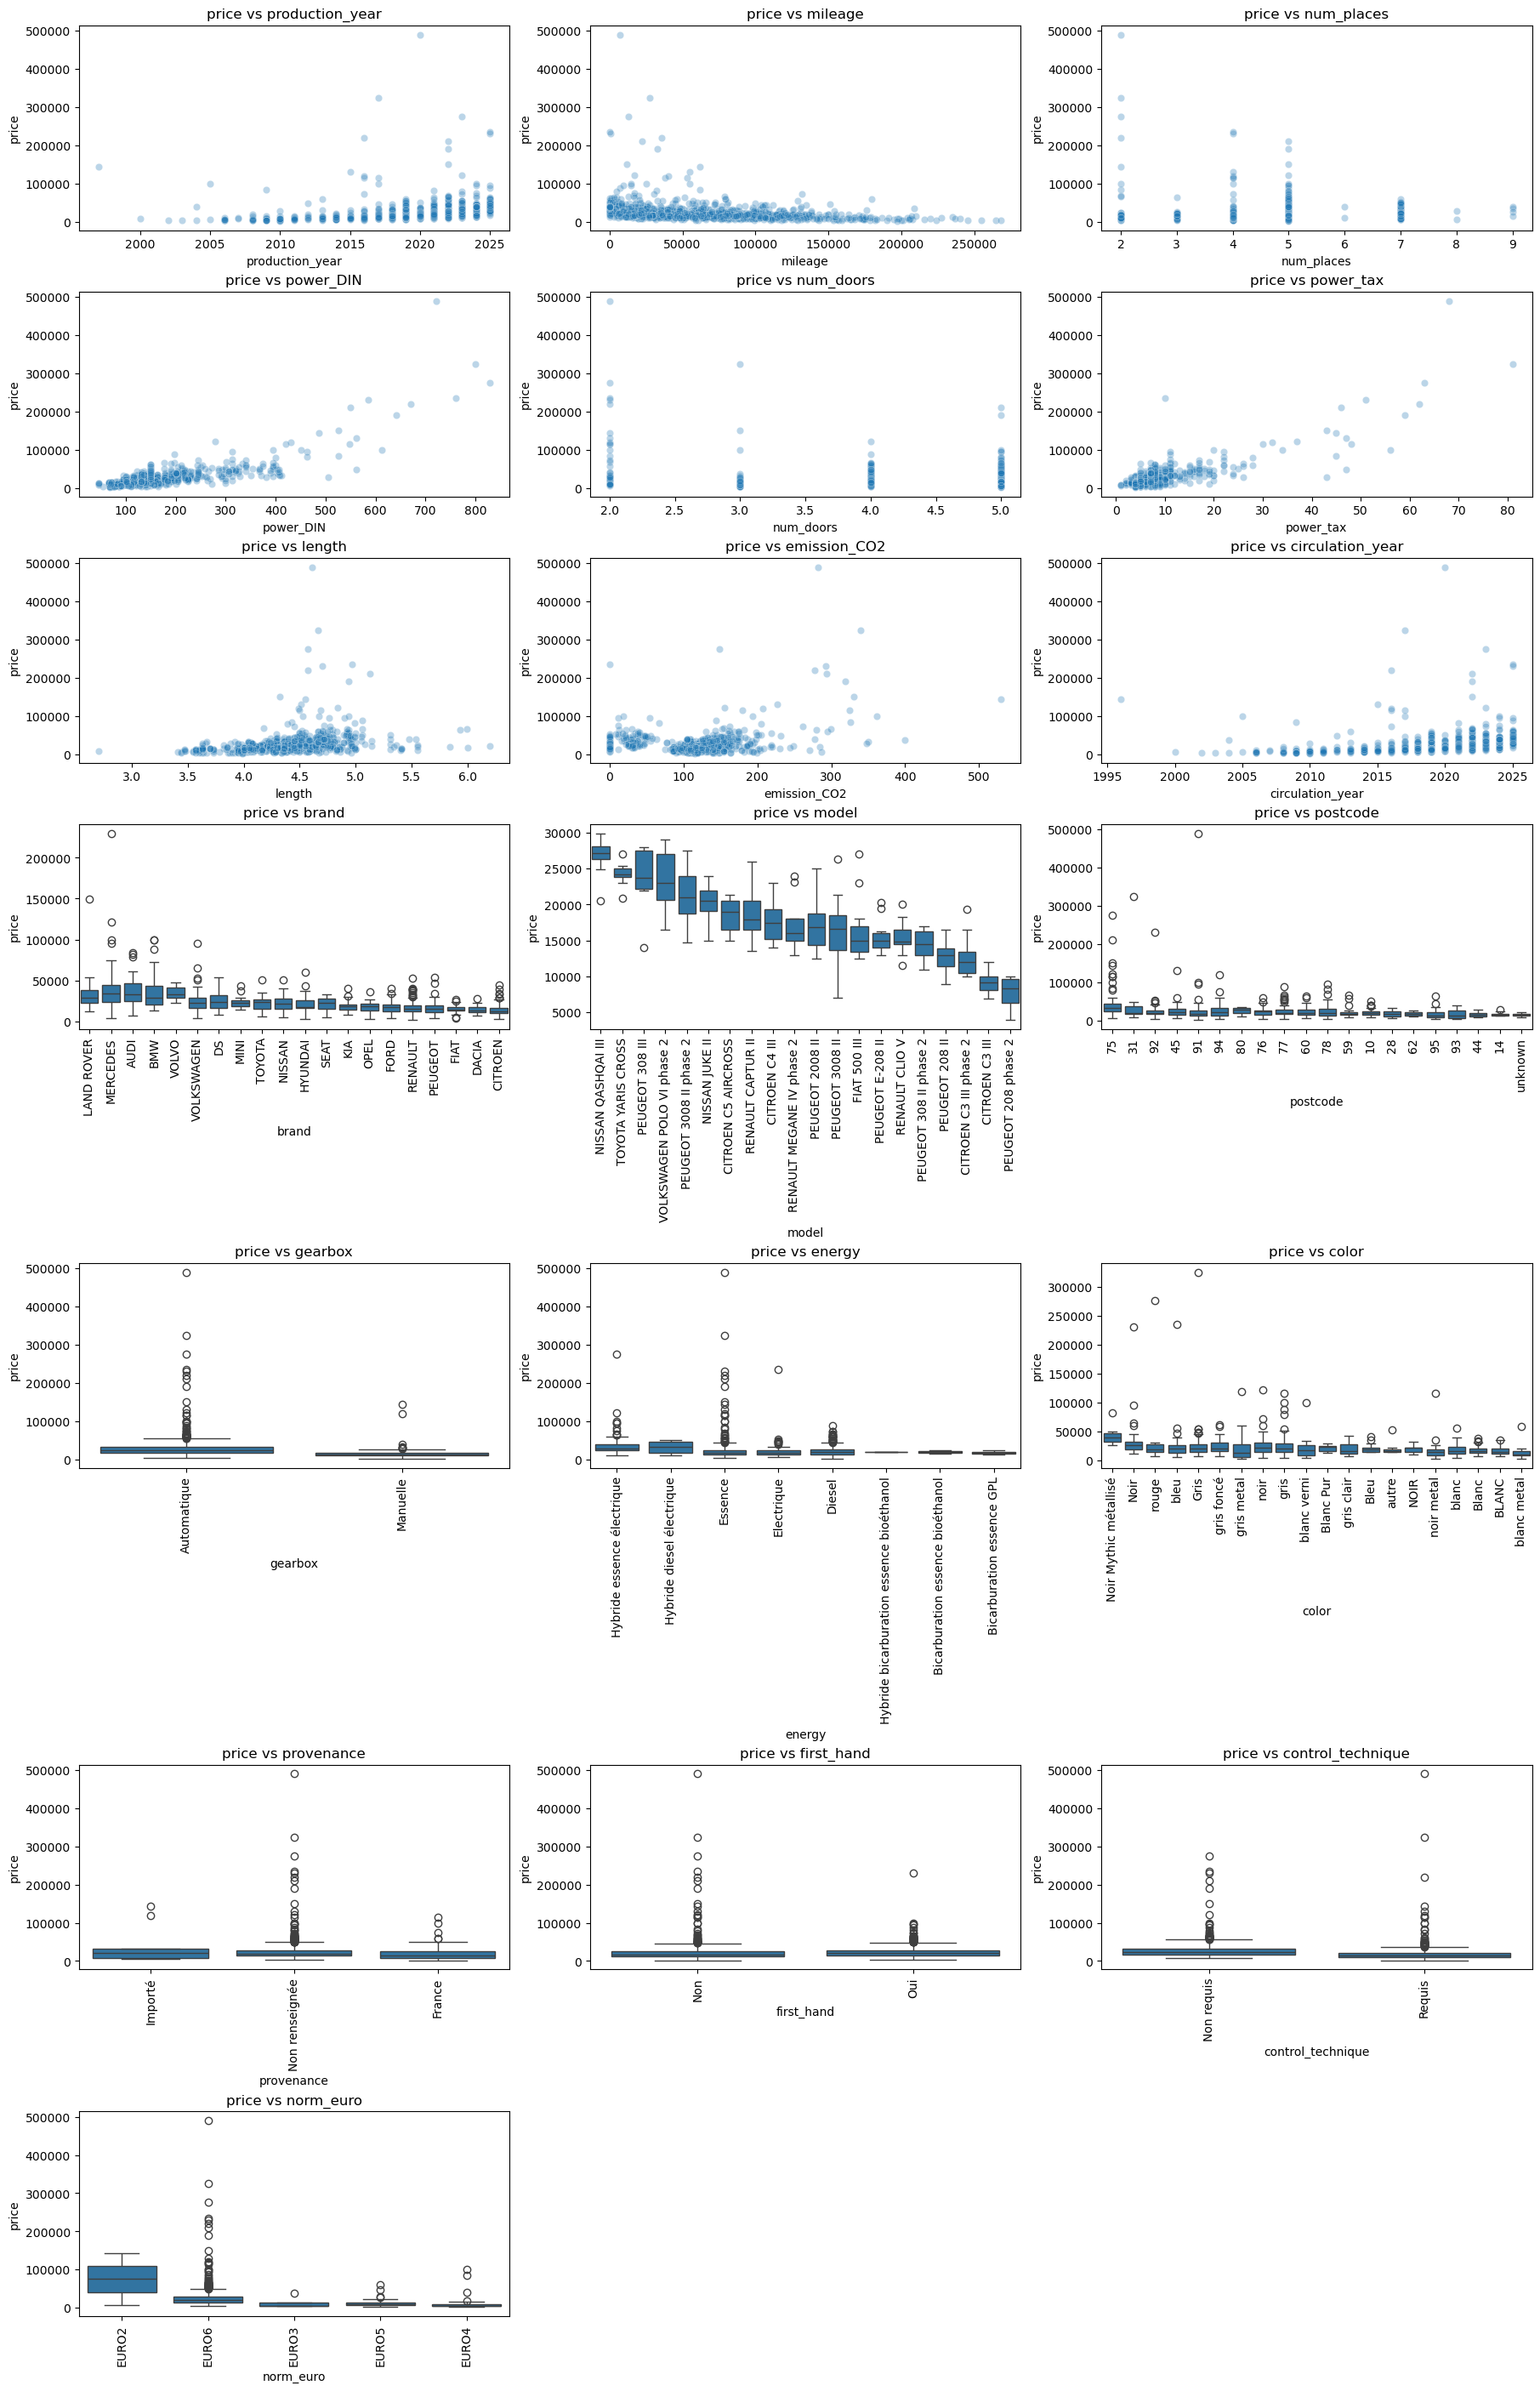

In [6]:
def plot_target_vs_features(df: pd.DataFrame, target: str):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    numerical_cols.remove(target)
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    all_cols = numerical_cols + categorical_cols
    
    c = 3
    r = math.ceil(len(all_cols) / c)
    fig, axes = plt.subplots(r, c, figsize=(c * 6, r * 4), constrained_layout=True)
    axes = axes.flatten()
    topk = 20
    
    for i, col in enumerate(all_cols):
        ax = axes[i]
        if col in numerical_cols:
            sns.scatterplot(data=df, x=col, y=target, ax=ax, alpha=0.3)
        else:
            # Keep top frequent categories
            top_categories = df[col].value_counts().nlargest(topk).index.tolist()
            df_filtered = df[df[col].isin(top_categories)]
            categories = (
                df_filtered.groupby(col)[target]
                .mean()
                .sort_values(ascending=False)
                .index
                .tolist()
            )
            sns.boxplot(data=df_filtered, x=col, y=target, ax=ax, order=categories)
            ax.tick_params(axis='x', labelrotation=90)
        ax.set_title(f"{target} vs {col}")
    # Hide unused axes
    for j in range(len(all_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.savefig("results/target_vs_features.png")
    plt.show()


plot_target_vs_features(df, target="price")

# Correlation

1. High correlated features with price.  
power_tax, power_DIN

3. Multicollinearity.  
('production_year', 'circulation_year'), ('power_DIN', 'power_tax')


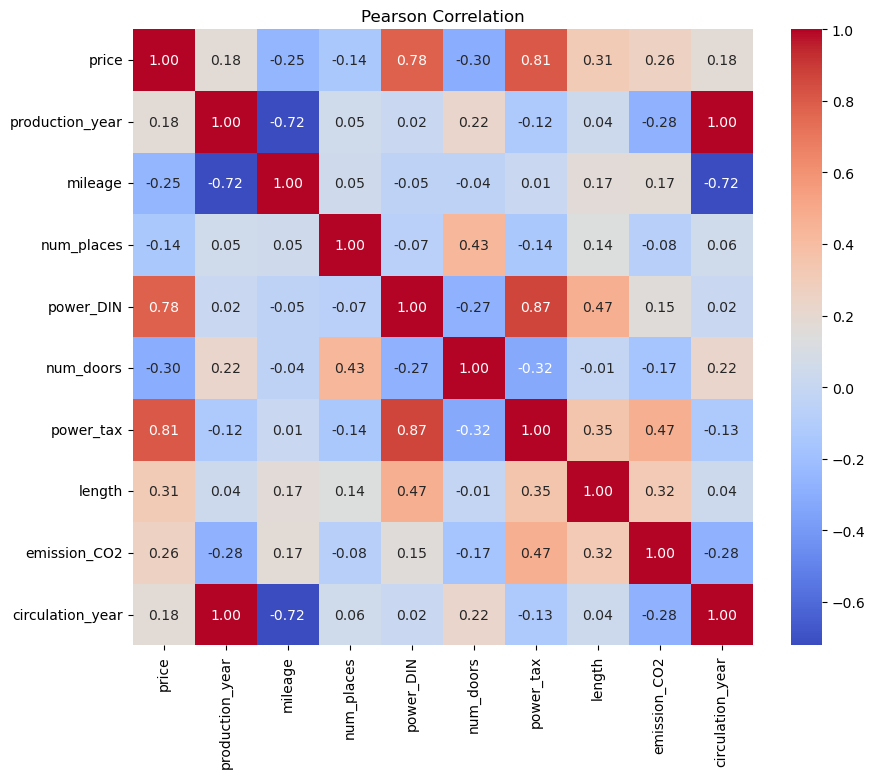

price               1.000000
power_tax           0.809156
power_DIN           0.782170
length              0.312882
num_doors           0.300667
emission_CO2        0.262518
mileage             0.254725
production_year     0.177634
circulation_year    0.176418
num_places          0.141283
Name: price, dtype: float64


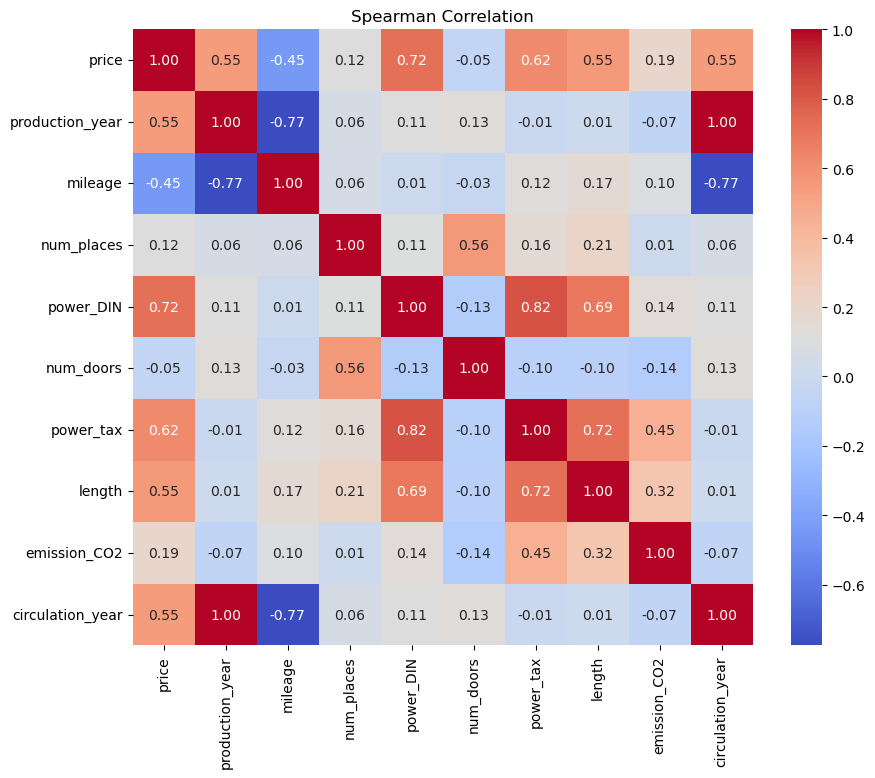

price               1.000000
power_DIN           0.717705
power_tax           0.618911
length              0.552244
production_year     0.547998
circulation_year    0.547998
mileage             0.446996
emission_CO2        0.193162
num_places          0.117468
num_doors           0.048452
Name: price, dtype: float64


In [7]:
def plot_corr(df: pd.DataFrame, target: str | None = None, method: str = "pearson"):
    df_numerical = df.select_dtypes(include=['number'])
    corr_matrix = df_numerical.corr(method=method)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"{method} Correlation".title())
    plt.show()

    if target:
        target_corr = corr_matrix["price"].abs().sort_values(ascending=False)
        
        print(target_corr)


plot_corr(df, target="price", method="pearson")
plot_corr(df, target="price", method="spearman")

In [8]:
def compute_corr_pairs(df: pd.DataFrame, threshold=0.8):
    """
    Compute correlation pairs to address multicollinearity
    """
    df_numerical = df.select_dtypes(include=['number'])
    corr_matrix = df_numerical.corr()
    
    pairs = []
    cols = corr_matrix.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            col1, col2 = cols[i], cols[j]
            corr = corr_matrix.loc[col1, col2]
            if abs(corr) > threshold:
                pairs.append((col1, col2, float(corr)))
    pairs = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
    print("\n-- Correlation Pairs --\n")
    print(pairs)


compute_corr_pairs(df)


-- Correlation Pairs --

[('production_year', 'circulation_year', 0.9999726921410493), ('power_DIN', 'power_tax', 0.8662820832254352), ('price', 'power_tax', 0.8091561894256003)]
